# GUSAIA

In [2]:
!git clone https://github.com/JunaidMuzamal/GUSAIA

Cloning into 'GUSAIA'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 7), reused 15 (delta 3), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [3]:
%cd GUSAIA

/content/GUSAIA


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from gusaia import *

In [5]:
!nvidia-smi -L

device = get_default_device()

GPU 0: Tesla T4 (UUID: GPU-71c0dab4-59e3-ef9c-621e-150afb8eb5d0)


## EDA - Data Pre-Processing

### Download dataset

In [6]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

input/SWaT_Dataset_Normal_v1.csv
[==================================================] 163.77MB/163.77MB
input/SWaT_Dataset_Attack_v0.csv
[==================================================] 127.27MB/127.27MB


### Normal period

In [7]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(495000, 51)

In [8]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [9]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [10]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(449919, 51)

In [11]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [12]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [13]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [13]:
window_size=12

In [14]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [15]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [16]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = GusaiaC(w_size, z_size)
model = to_device(model,device)

In [18]:
history = fit(N_EPOCHS,model,train_loader,val_loader)

Epoch 0, D1_loss: 0.0263, D2_loss: 0.0257
Epoch 1, D1_loss: 0.0295, D2_loss: -0.0033
Epoch 2, D1_loss: 0.0342, D2_loss: -0.0185
Epoch 3, D1_loss: 0.0442, D2_loss: -0.0236
Epoch 4, D1_loss: 0.0350, D2_loss: -0.0228
Epoch 5, D1_loss: 0.0303, D2_loss: -0.0216
Epoch 6, D1_loss: 0.0301, D2_loss: -0.0226
Epoch 7, D1_loss: 0.0339, D2_loss: -0.0269
Epoch 8, D1_loss: 0.0377, D2_loss: -0.0310
Epoch 9, D1_loss: 0.0302, D2_loss: -0.0250
Epoch 10, D1_loss: 0.0302, D2_loss: -0.0254
Epoch 11, D1_loss: 0.0303, D2_loss: -0.0258
Epoch 12, D1_loss: 0.0307, D2_loss: -0.0266
Epoch 13, D1_loss: 0.0305, D2_loss: -0.0267
Epoch 14, D1_loss: 0.0307, D2_loss: -0.0271
Epoch 15, D1_loss: 0.0308, D2_loss: -0.0274
Epoch 16, D1_loss: 0.0310, D2_loss: -0.0279
Epoch 17, D1_loss: 0.0311, D2_loss: -0.0281
Epoch 18, D1_loss: 0.0314, D2_loss: -0.0285
Epoch 19, D1_loss: 0.0309, D2_loss: -0.0282
Epoch 20, D1_loss: 0.0315, D2_loss: -0.0289
Epoch 21, D1_loss: 0.0310, D2_loss: -0.0285
Epoch 22, D1_loss: 0.0322, D2_loss: -0.0297

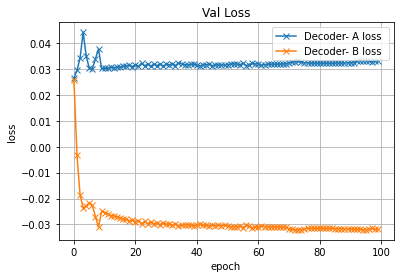

In [19]:
plot_history(history)

In [21]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [17]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [18]:
results=validate(model,test_loader)

In [19]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [20]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [21]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

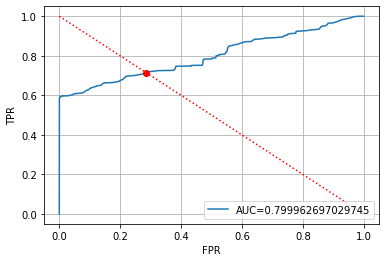

In [27]:
threshold=ROC(y_test,y_pred)

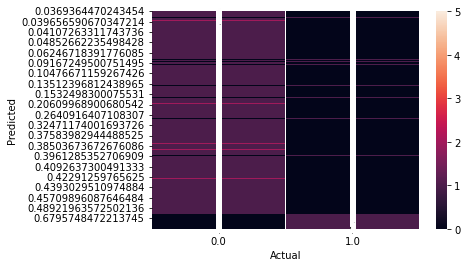

In [22]:
confusion_matrix(y_test,y_pred)